In [1]:
install.packages('ergm')

Installing package into ‘/home/luciano/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



In [2]:
#library(networkdata)
library(ergm)

Loading required package: network

network: Classes for Relational Data
Version 1.16.1 created on 2020-10-06.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



ergm: version 3.11.0, created on 2020-10-14
Copyright (c) 2020, Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Carter T. Butts, University of California -- Irvine
                    Steven M. Goodreau, University of Washington
                    Pavel N. Krivitsky, UNSW Sydney
                    Martina Morris, University of Washington
                    with 

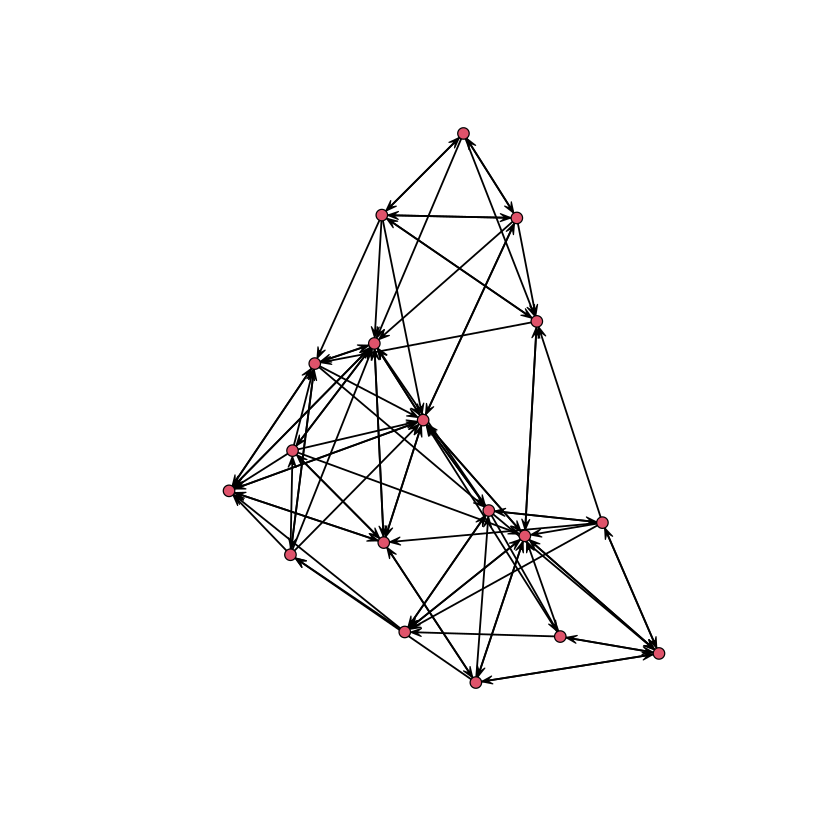

In [3]:
data('sampson');y <- as.matrix(samplike)
plot(samplike)

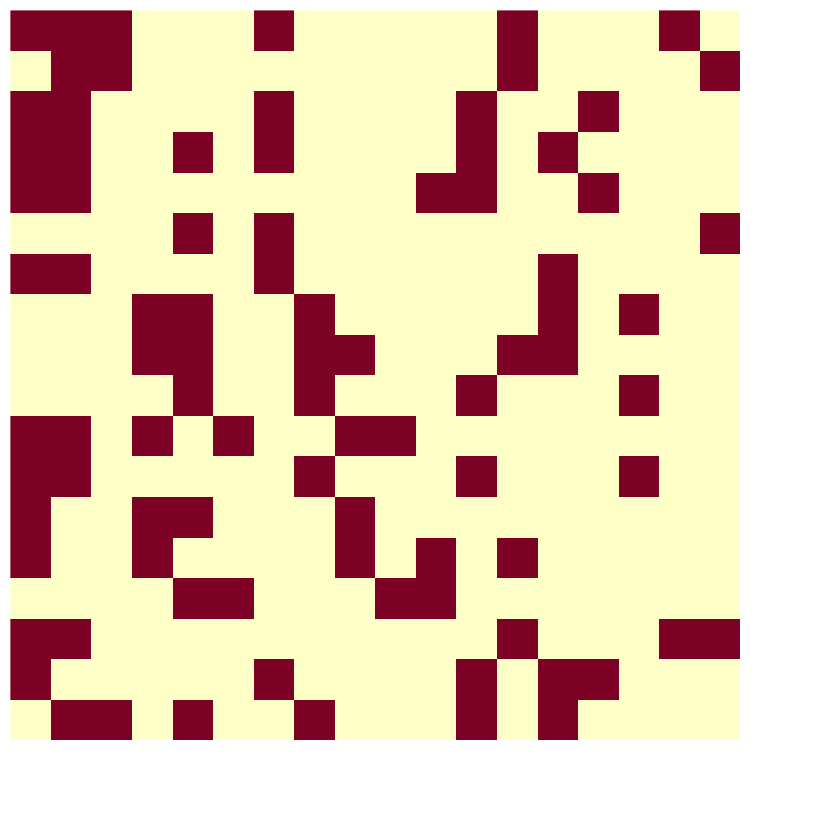

In [4]:
heatmap(y, scale = "none", Rowv = NA, Colv = NA, labRow = FALSE, labCol = FALSE)

In [5]:
gen_features <- function(y){
    n <- dim(y)[1]
    network_sum <- sum(y)
    mutual <- (sum(t(y)*y) - sum(diag(y)))/2
    final = c(network_sum,mutual)
    return(final)
}
g_obs <- gen_features(y); g_obs

[1] 88 28

In [6]:
model <- ergm(samplike~edges+mutual)
summary(model)

Starting maximum pseudolikelihood estimation (MPLE):

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Starting Monte Carlo maximum likelihood estimation (MCMLE):

Iteration 1 of at most 20:

Optimizing with step length 1.

The log-likelihood improved by 0.0005863.

Step length converged once. Increasing MCMC sample size.

Iteration 2 of at most 20:

Optimizing with step length 1.

The log-likelihood improved by 0.001393.

Step length converged twice. Stopping.

Finished MCMLE.

Evaluating log-likelihood at the estimate. 
Using 20 bridges: 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
.

This model was fit using MCMC.  To examine model diagnostics and check
for degeneracy, use the mcmc.diagnostics() function.



Call:
ergm(formula = samplike ~ edges + mutual)

Iterations:  2 out of 20 

Monte Carlo MLE Results:
       Estimate Std. Error MCMC % z value Pr(>|z|)    
edges   -1.7592     0.2056      0  -8.555   <1e-04 ***
mutual   2.3238     0.4197      0   5.536   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 424.2  on 306  degrees of freedom
 Residual Deviance: 332.2  on 304  degrees of freedom
 
AIC: 336.2    BIC: 343.7    (Smaller is better.) 

In [7]:
gen_MCMC <- function(nsim, eta){
    n <- 18
    y_syn <- matrix(sample(c(0,1),n*n,replace=T),ncol=n,nrow=n)
    diag(y_syn) <- rep(0,n)
    holder <- list()
    for(MCMC_iter in 1:nsim){
        flip_counter <- 0
        while(flip_counter <= n*n){
            #randomly pick a location
            x <- sample(1:n,1)
            y <- sample(1:n,1)
            if(x!=y){
                y_temp <- y_syn
                y_temp[x,y] <- 1
                Z_y_1 <- gen_features(y_temp)
                y_temp[x,y] <- 0
                Z_y_0 <- gen_features(y_temp)
                delta_Z <- Z_y_1 - Z_y_0
                 
                u <- runif(1)
                if(y_syn[x,y] == 0){
                    accept_ratio <- min(1,exp(eta %*% delta_Z))
                    if(u < accept_ratio){y_syn[x,y] <- 1}
                }else if(y_syn[x,y] == 1){
                    accept_ratio <- min(1,exp(-eta %*% delta_Z))
                    if(u < accept_ratio){y_syn[x,y] <- 0}
                }
            } # end of 1 update at (x,y)
            flip_counter <- flip_counter + 1
        } # end of 1 sweep
        holder[[MCMC_iter]] <- y_syn
    } # end of n simulation
    return(holder)
}

gen_features_MCMC <- function(MCMC_list){
    n <- length(MCMC_list)
    holder <- matrix(0,nrow=n,ncol=2)
    for(gen_f_iter in 1:n){
        holder[gen_f_iter,] <- gen_features(MCMC_list[[gen_f_iter]])
    }
    return(holder)
}

In [8]:
# Method 1
eta <- c(0,0)
for(iter in 1:50){
    MCMC_list <- simulate(network(18) ~ edges + mutual, coef=eta, nsim=500)
    MCMC_list_features <- summary(MCMC_list ~ edges + mutual)
    eta <- eta + 0.01 * (g_obs - colMeans(MCMC_list_features))
}
cat('eta: ',eta)

eta:  -1.68386 2.15256

In [9]:
# Method 2
eta <- c(0,0)
for(iter in 1:10){
    MCMC_list <- simulate(network(18) ~ edges + mutual, coef=eta, nsim=500)
    MCMC_list_features <- summary(MCMC_list ~ edges + mutual)
    S <- g_obs - colMeans(MCMC_list_features)
    H <- var(MCMC_list_features)
    eta <- eta + solve(H)%*%S
}
cat('eta: ',eta)

eta:  -1.754369 2.299117

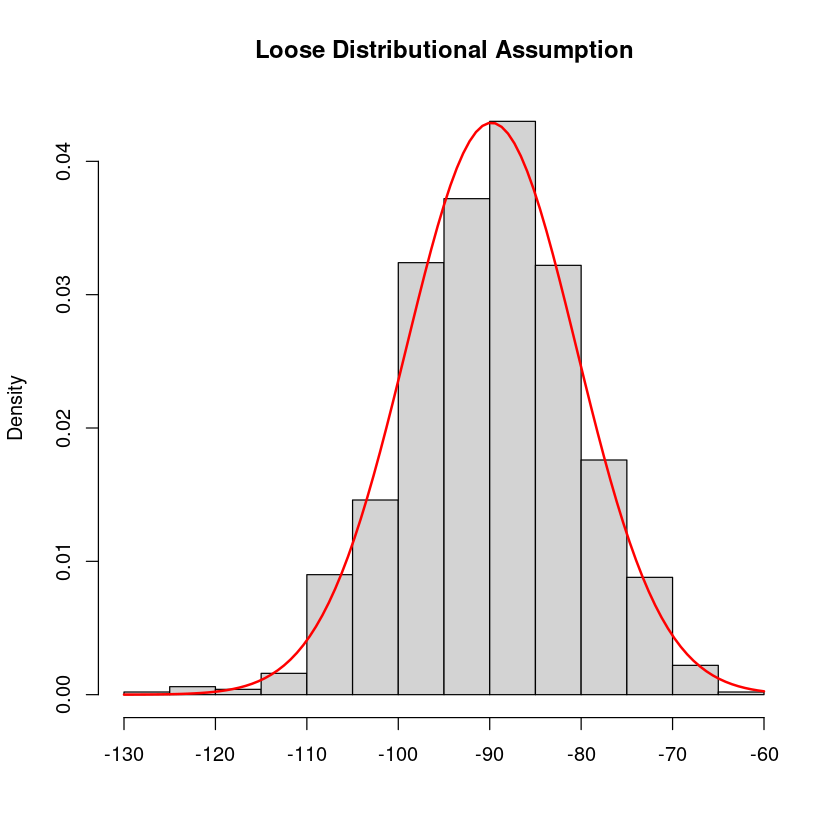

In [10]:
eta <- coef(model)
g.sim <- simulate(network(18) ~ edges + mutual, coef=eta, nsim=1000)
g.sim.test <- summary(g.sim ~ edges + mutual)
mu <- colMeans(g.sim.test) %*% eta
variance <- t(eta) %*% cov(g.sim.test) %*% eta
x <- seq(-120,-60,by=0.1)
hist(g.sim.test %*% eta, main='Loose Distributional Assumption',
freq = F,xlab = '')
curve(dnorm(x,mean = mu, sd = sqrt(variance)), add=TRUE, col='red', lwd=2)

In [11]:
eta_learning <- function(learning_iter, MCMC_size, g_obs, par_gamma){
    eta <- c(0,0)
    llr_sum <- -choose(18,2) * log(2)
    for(l_iter in 1:learning_iter){
        MCMC_list <- simulate(network(18) ~ edges + mutual, coef=eta, nsim=MCMC_size)
        MCMC_list_features <- summary(MCMC_list ~ edges + mutual)
        #MCMC_list <- gen_MCMC(MCMC_size, eta)
        #MCMC_list_features <- gen_features_MCMC(MCMC_list)
        xi_sample_mean <- colMeans(MCMC_list_features)
        cov_matrix <- cov(MCMC_list_features)
        xi_hat <- par_gamma * g_obs + (1-par_gamma) * xi_sample_mean
        eta_old <- eta
        eta <- c(eta + solve(cov_matrix) %*% (xi_hat - xi_sample_mean))
        cat('iter =',l_iter,', eta = (',eta,')','\n')
    }
    eta_se <- diag(solve(var(MCMC_list_features)))
    cat('\n')
    cat('eta:',eta,'\n')
    cat('standard error:',eta_se,'\n')
    return(MCMC_list_features)
}

In [12]:
eta_learning2 <- function(MCMC_sample_size, learning_iter, etak, g_obs){
  # Normalizing eta won't change probability (see normalization term)
  etak <- etak / sqrt(sum(etak^2))
  
  # Step 2 of algorithm: generate MCMC sample using eta0
  eta0 <- etak
  MCMC_list <- simulate(network(18) ~ edges + mutual, coef=eta0, nsim=MCMC_sample_size)
  MCMC_list_features <- summary(MCMC_list ~ edges + mutual);rm(MCMC_list)
  p <- dim(MCMC_list_features)[2]
  
  for(iter in 1:learning_iter){    
    # initialize place holder
    wi_vector <- numeric(MCMC_sample_size)
    wi_ZiZi <- I_hat <- outer(numeric(p),numeric(p))
    wi_Zi <- numeric(p)
    
    # trick: avoid wi to explode
    for(i in 1:MCMC_sample_size){
      wi_vector[i] <- c((etak-eta0) %*% MCMC_list_features[i,])
    }
    wi_vector <- exp(wi_vector - max(wi_vector))
    wi_vector <- wi_vector/sum(wi_vector)
    
    # construct input for equation (3.5)
    for(i in 1:MCMC_sample_size){
      Zi <- MCMC_list_features[i,]
      wi_Zi <- wi_Zi + wi_vector[i]*Zi
    }
    
    # equation (3.5)
    for(i in 1:MCMC_sample_size){
      Zi <- MCMC_list_features[i,]
      I_hat <- I_hat + wi_vector[i]*outer(Zi,Zi) - outer(wi_Zi,wi_Zi)
    }
    
    # equation (3.4)
    etak <- c(etak + solve(I_hat) %*% (g_obs - wi_Zi))
    etak <- etak / sqrt(sum(etak^2))
    
  } # end of eta learning
  
  cat('eta =', etak)
  
  return(etak)
}

In [13]:
eta_learning3 <- function(MCMC_sample_size, learning_iter, etak, g_obs){
  # Normalizing eta won't change probability (see normalization term)
  etak <- etak / sqrt(sum(etak^2))
  
  # Step 2 of algorithm: generate MCMC sample using eta0
  eta0 <- etak
  MCMC_list <- simulate(network(18) ~ edges + mutual, coef=eta0, nsim=MCMC_sample_size)
  Z <- summary(MCMC_list ~ edges + mutual);rm(MCMC_list)
    
  for(iter in 1:learning_iter){
    w <- Z %*% (etak-eta0)
    w <- exp(w - max(w))
    w <- w/sum(w)

    wZ <- array(w, dim(Z)) * Z
    wZ_colsum <- colSums(wZ)
    wZZ_sum <- t(wZ) %*% Z

    I_hat <- wZZ_sum - (matrix(wZ_colsum, ncol=1) %*% wZ_colsum)
      
    etak <- c(etak + solve(I_hat) %*% (g_obs - wZ_colsum))
    etak <- etak / sqrt(sum(etak^2))
    
  } # end of eta learning
  
  cat('eta =', etak)
  
  return(etak)
}

iter = 1 , eta = ( -0.9393479 1.114315 ) 
iter = 2 , eta = ( -1.361556 1.678312 ) 
iter = 3 , eta = ( -1.548988 1.972204 ) 
iter = 4 , eta = ( -1.648639 2.139828 ) 
iter = 5 , eta = ( -1.69548 2.21525 ) 
iter = 6 , eta = ( -1.725699 2.2629 ) 
iter = 7 , eta = ( -1.737631 2.283643 ) 
iter = 8 , eta = ( -1.748776 2.303135 ) 
iter = 9 , eta = ( -1.752777 2.311851 ) 
iter = 10 , eta = ( -1.759702 2.318965 ) 

eta: -1.759702 2.318965 
standard error: 0.0420462 0.1647756 


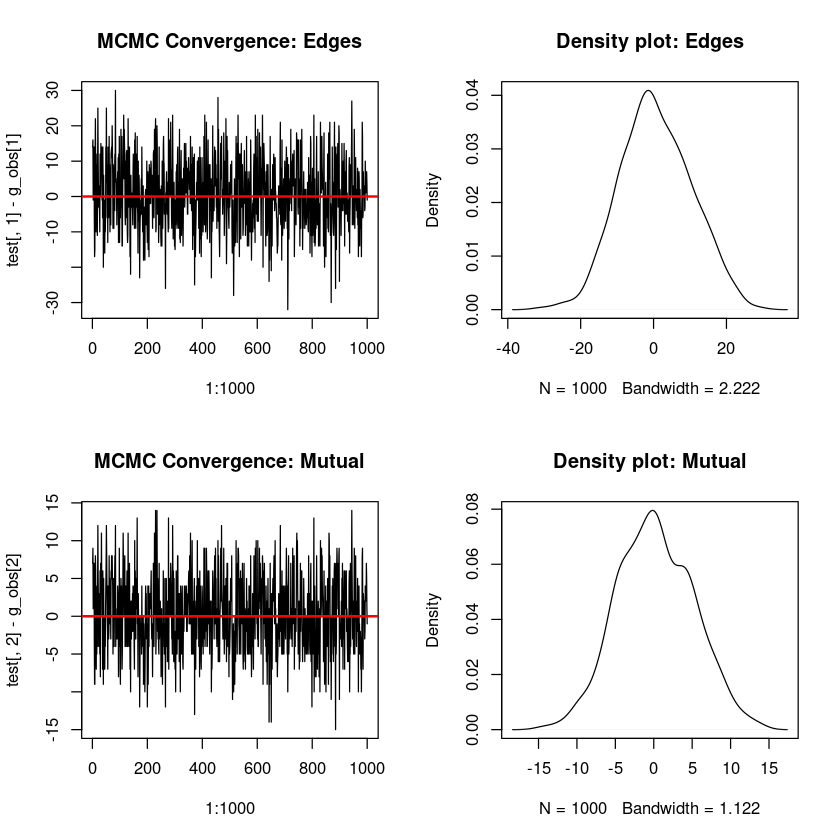

In [14]:
test <- eta_learning(10, 1000, g_obs, 0.5)

par(mfrow=c(2,2))
plot(1:1000,test[,1]-g_obs[1],type='l',xlab=NULL,main='MCMC Convergence: Edges')
abline(h=0,col='red',lwd=2)
plot(density(test[,1]-g_obs[1]),main='Density plot: Edges')
plot(1:1000,test[,2]-g_obs[2],type='l',xlab=NULL,main='MCMC Convergence: Mutual')
abline(h=0,col='red',lwd=2)
plot(density(test[,2]-g_obs[2]),main='Density plot: Mutual')

In [15]:
g_obs <- summary(samplike~edges+mutual)
etak <- eta_learning2(1000,500,c(-2,-2),g_obs)

eta = -0.1686982 0.9856678

In [16]:
# true value (parameter estimation)
res <- ergm(samplike~edges+mutual)
summary(res)

Starting maximum pseudolikelihood estimation (MPLE):

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Starting Monte Carlo maximum likelihood estimation (MCMLE):

Iteration 1 of at most 20:

Optimizing with step length 1.

The log-likelihood improved by 0.00122.

Step length converged once. Increasing MCMC sample size.

Iteration 2 of at most 20:

Optimizing with step length 1.

The log-likelihood improved by 0.0006412.

Step length converged twice. Stopping.

Finished MCMLE.

Evaluating log-likelihood at the estimate. 
Using 20 bridges: 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
.

This model was fit using MCMC.  To examine model diagnostics and check
for degeneracy, use the mcmc.diagnostics() function.



Call:
ergm(formula = samplike ~ edges + mutual)

Iterations:  2 out of 20 

Monte Carlo MLE Results:
       Estimate Std. Error MCMC % z value Pr(>|z|)    
edges    -1.762      0.205      0  -8.595   <1e-04 ***
mutual    2.322      0.414      0   5.609   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 424.2  on 306  degrees of freedom
 Residual Deviance: 332.2  on 304  degrees of freedom
 
AIC: 336.2    BIC: 343.6    (Smaller is better.) 

In [17]:
res[[1]]/sqrt(sum(res[[1]]^2))

edges     mutual 
-0.6045340  0.7965793